In [66]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, models, transforms, utils
import os, time, copy, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import kagglehub

In [67]:
#acquiring the data set
path = kagglehub.dataset_download("atulyakumar98/pothole-detection-dataset")

Using Colab cache for faster access to the 'pothole-detection-dataset' dataset.


In [68]:
#path correction
!ls -R {path}
data_dir = os.path.join(path, 'Pothole_Detection_Dataset')
# ... verification code ...

/kaggle/input/pothole-detection-dataset:
normal	potholes

/kaggle/input/pothole-detection-dataset/normal:
100.jpg  137.jpg  173.jpg  209.jpg  245.jpg  281.jpg  317.jpg  35.jpg  71.jpg
101.jpg  138.jpg  174.jpg  20.jpg   246.jpg  282.jpg  318.jpg  36.jpg  72.jpg
102.jpg  139.jpg  175.jpg  210.jpg  247.jpg  283.jpg  319.jpg  37.jpg  73.jpg
103.jpg  13.jpg   176.jpg  211.jpg  248.jpg  284.jpg  31.jpg   38.jpg  74.jpg
104.jpg  140.jpg  177.jpg  212.jpg  249.jpg  285.jpg  320.jpg  39.jpg  75.jpg
105.jpg  141.jpg  178.jpg  213.jpg  24.jpg   286.jpg  321.jpg  3.jpg   76.jpg
106.jpg  142.jpg  179.jpg  214.jpg  250.jpg  287.jpg  322.jpg  40.jpg  77.jpg
107.jpg  143.jpg  17.jpg   215.jpg  251.jpg  288.jpg  323.jpg  41.jpg  78.jpg
108.jpg  144.jpg  180.jpg  216.jpg  252.jpg  289.jpg  324.jpg  42.jpg  79.jpg
109.jpg  145.jpg  181.jpg  217.jpg  253.jpg  28.jpg   325.jpg  43.jpg  7.jpg
10.jpg	 146.jpg  182.jpg  218.jpg  254.jpg  290.jpg  326.jpg  44.jpg  80.jpg
110.jpg  147.jpg  183.jpg  219.jpg  25

In [69]:
# Data Augmentation and Transforms ---

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Data transforms defined successfully.")

Data transforms defined successfully.


In [70]:
#  Datasets and Dataloaders ---

# First, we load the entire dataset.
full_dataset = datasets.ImageFolder(path)
class_names = full_dataset.classes
print(f"Classes found: {class_names}")

#  calculate the sizes for an 80/20 split before using them.
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

#  we can use train_size and val_size to split the dataset.
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Applying the correct transformations to our new train and validation sets.
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create the dataloaders from our correctly split datasets.
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
print(f"Training set size: {dataset_sizes['train']}")
print(f"Validation set size: {dataset_sizes['val']}")

Classes found: ['normal', 'potholes']
Training set size: 544
Validation set size: 137


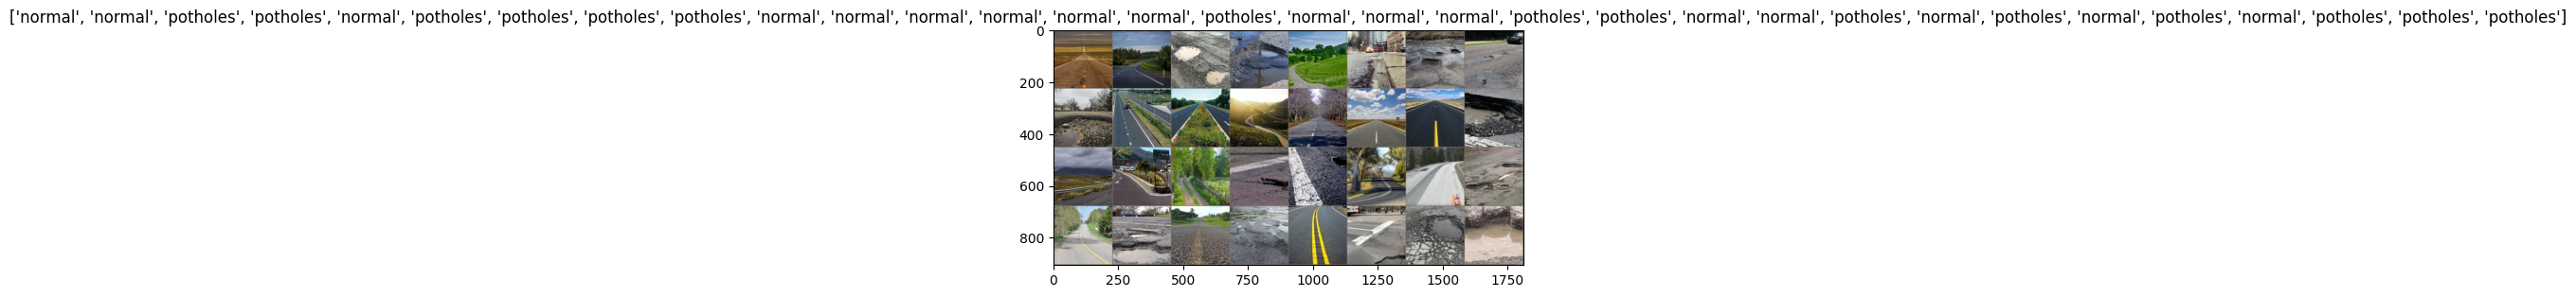

In [71]:
inputs, classes = next(iter(dataloaders['train']))
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [72]:
# Model Preparation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Load the pre-trained model using the recommended 'weights' keyword.
model_ft = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# freezing all the pretrained layers
for param in model_ft.parameters():
    param.requires_grad = False

# 1. Get the number of input features for the classifier layer.
num_ftrs = model_ft.classifier[1].in_features

model_ft.classifier[1] = nn.Linear(in_features=num_ftrs, out_features=len(class_names))

# Move the entire model to the correct device (CPU or GPU).
model_ft = model_ft.to(device)

# Define the loss function.
criterion = nn.CrossEntropyLoss()

# Tell the optimizer to only update the parameters of our new classifier layer.
optimizer_ft = optim.Adam(model_ft.classifier.parameters(), lr=0.001)



Using device: cpu


In [73]:
#training the model
def train_model(model, criterion, optimizer, dataset_sizes, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [74]:
model_ft = train_model(model_ft, criterion, optimizer_ft, dataset_sizes, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4918 Acc: 0.8493
val Loss: 0.3345 Acc: 0.9635
Epoch 1/9
----------
train Loss: 0.2719 Acc: 0.9596
val Loss: 0.2175 Acc: 0.9708
Epoch 2/9
----------
train Loss: 0.2132 Acc: 0.9577
val Loss: 0.1756 Acc: 0.9635
Epoch 3/9
----------
train Loss: 0.1737 Acc: 0.9540
val Loss: 0.1452 Acc: 0.9562
Epoch 4/9
----------
train Loss: 0.1467 Acc: 0.9651
val Loss: 0.1416 Acc: 0.9635
Epoch 5/9
----------
train Loss: 0.1386 Acc: 0.9669
val Loss: 0.1203 Acc: 0.9635
Epoch 6/9
----------
train Loss: 0.1355 Acc: 0.9651
val Loss: 0.1256 Acc: 0.9635
Epoch 7/9
----------
train Loss: 0.1243 Acc: 0.9669
val Loss: 0.1079 Acc: 0.9562
Epoch 8/9
----------
train Loss: 0.0945 Acc: 0.9816
val Loss: 0.1133 Acc: 0.9635
Epoch 9/9
----------
train Loss: 0.1058 Acc: 0.9688
val Loss: 0.1055 Acc: 0.9708
Training complete in 10m 46s
Best val Acc: 0.970803


In [75]:
torch.save(model_ft.state_dict(), 'pothole_classifier_model.pth')
print("\nModel saved as pothole_classifier_model.pth")

def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    image_transformed = data_transforms['val'](image)
    image_transformed = image_transformed.unsqueeze(0)
    image_transformed = image_transformed.to(device)

    with torch.no_grad():
        outputs = model(image_transformed)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds[0]]

    plt.imshow(image)
    plt.title(f'Prediction: {predicted_class}')
    plt.axis('off')
    plt.show()


Model saved as pothole_classifier_model.pth


In [ ]:
print("\n--- Interactive Prediction ---")
print("Please upload an image file to classify.")
uploaded = files.upload()

if uploaded:
    image_name = next(iter(uploaded))
    print(f"\nUser uploaded image: {image_name}")
    predict_image(image_name, model_ft)
else:
    print("No file uploaded.")


--- Interactive Prediction ---
Please upload an image file to classify.
